# 1. Describing The Case

<font size="4" color='green'>This is the case of Polish companies with a bankruptcy classifier. There are 64 features of each company, each of which had some kind of numerical value.</font>

<font size="4" color='green'>Dataset: </font>[link](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data)


<font size="4" color='green'>Used model: DecisionTreeClassifier, Random Forest and Gradient Boosting wrapping the pipeline. 
Developed models solved the problem of imbalanced data by under- and over-sampling, and the problem of missing data.</font>






# 2. Prepare Data

## import 

In [1]:
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from colorama import Fore

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## data wrangling

In [2]:
def wrangle(N):
    
    df = pd.DataFrame()
    
    for i in range(N):
        pathfile = 'data/' + str(i+1) + 'year.json'
        data = json.load(open(pathfile))
        _ = pd.DataFrame().from_dict(data)
        df = pd.concat([df, _])
        
    return df

In [3]:
df = wrangle(5)
print(df.shape)
df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


### Bar chart of the value counts for the "class" column

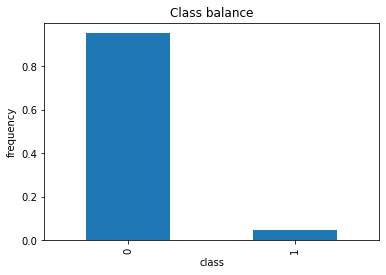

In [4]:
# Plot class balance
df["class"].value_counts(normalize=True).plot(
        kind="bar", xlabel='class', ylabel='frequency', title="Class balance"
);

In [5]:
# Calculate variance, get 5 largest features
top_five_var = df[:-1].var().sort_values().tail()
lst_five_var = top_five_var.index.to_list()

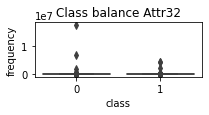

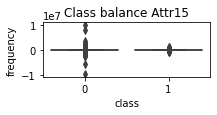

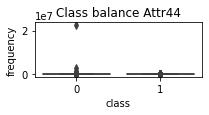

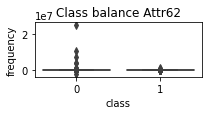

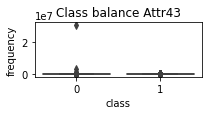

In [6]:
for i in df[lst_five_var]: 
    plt.figure(figsize=(3,1))
    sns.boxplot(x="class", y=i, data=df)
    plt.xlabel("class")
    plt.ylabel("frequency")
    plt.title(f"Class balance {i}")
    plt.show();

<font size="4" color='red'>The data is very imbalanced</font>

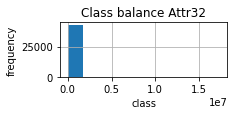

Attr32 is Right-Skewed


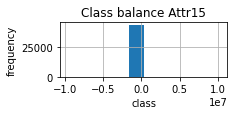

Attr15 is Right-Skewed


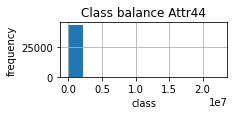

Attr44 is Right-Skewed


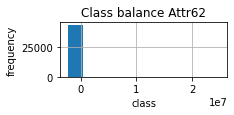

Attr62 is Right-Skewed


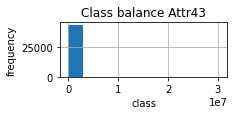

Attr43 is Right-Skewed


In [7]:
for i in df[lst_five_var]:
    plt.figure(figsize=(3,1))
    df[i].hist()
    plt.xlabel("class")
    plt.ylabel("frequency")
    plt.title(f"Class balance {i}")
    plt.show()
    if df[i].median() != 0:
        if (df[i].mean() - df[i].median() / df[i].median()) > 1:
            print(f"{i} is Right-Skewed")
        elif (df[i].mean() - df[i].median() / df[i].median()) < 1:
            print("{i} is Left-Skewed")
        else: 
            print("{i} is Probably Normal")
    else: 
        print("{i} is Probably Normal")

<font size="4" color='red'>The features are highly skewed</font>

### Plot a correlation heatmap of features

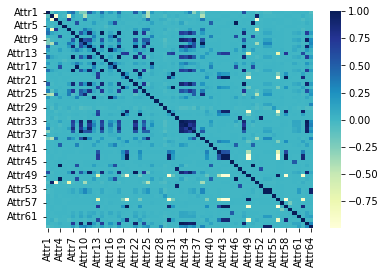

In [8]:
corr = df.drop(columns="class").corr()
sns.heatmap(corr, cmap="YlGnBu");


<font size="4" color='red'>The data have missing values</font>


<font size="4" color='red'>The data is imbalanced and many of features have missing values that need to impute. The features are highly skewed, the best imputation strategy is likely median, not mean.</font>


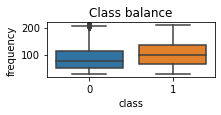

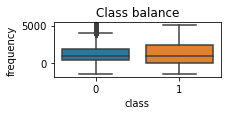

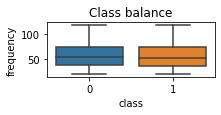

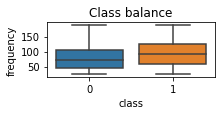

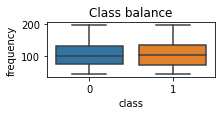

In [9]:
for i in df[lst_five_var]: 
    plt.figure(figsize=(3,1))
    q1, q9 = df[i].quantile([0.1,0.9])
    mask = df[i].between(q1, q9)
    sns.boxplot(x="class", y=i, data=df[mask])
    plt.xlabel("class")
    plt.ylabel("frequency")
    plt.title("Class balance")
    plt.show();

# 3. Split data

In [10]:
# Create feature matrix X and target vector y
target = "class"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (43405, 64)
y shape: (43405,)


In [11]:
# Divide data into training and test sets using a randomized train-test split. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34724, 64)
y_train shape: (34724,)
X_test shape: (8681, 64)
y_test shape: (8681,)


## undersampling and oversampling imbalaced data

In [12]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print("X_train_under shape:", X_train_under.shape)

over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)

X_train_under shape: (3300, 64)
X_train_over shape: (66148, 64)


## establish the baseline

In [13]:
acc_baseline = df[target].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9518


# 4. Create and evaluate three identical models:

In [14]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [15]:
count = 1

for m in [model_reg, model_under, model_over]:
    
    acc_test = accuracy_score(y_test, m.predict(X_test))
    precision_test = accuracy_score(y_test, m.predict(X_test))
    recall_score_test = recall_score(y_test, m.predict(X_test), average='macro')    
    f1_score_test = f1_score(y_test, m.predict(X_test), average='macro')
    print(Fore.RED + f"Model # {count}")
    count += 1
    print(Fore.BLUE + "Accuracy:", round(acc_test, 4))
    print("Precision:", round(precision_test, 4))
    print("Recall:", round(recall_score_test, 4))
    print("F1_Score:", round(f1_score_test, 4))

Model # 1
Accuracy: 0.9499
Precision: 0.9499
Recall: 0.7515
F1_Score: 0.7459
Model # 2
Accuracy: 0.7879
Precision: 0.7879
Recall: 0.7896
F1_Score: 0.5754
Model # 3
Accuracy: 0.9521
Precision: 0.9521
Recall: 0.7451
F1_Score: 0.7483


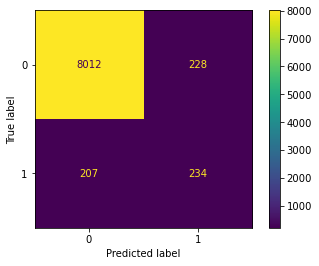

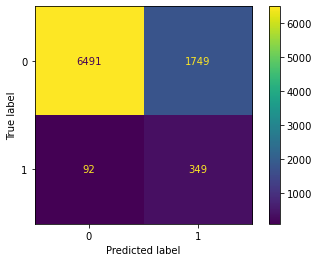

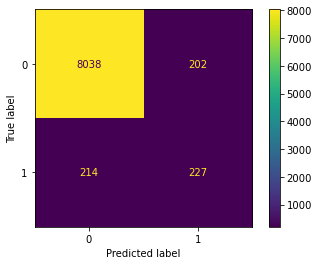

In [16]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(model_under, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(model_over, X_test, y_test);


<font size="4" color='red'>
   The best F1_Score and Precision for the model_over. Although, for bankruptcy cases, the Recall metric and the largest False Negative can be more important than other metrics. It may also depend on the amount of losses
</font>

In [17]:
# current depth for model_under
depth = model_under.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

24


# 5. Make pipeline with DecisionTreeClassifier

In [18]:
clf = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])


In [19]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.98662132 0.98601663 0.98654573 0.98677149 0.98699826]


In [20]:
params = {
    "simpleimputer__strategy": ["median"],
    "decisiontreeclassifier__max_depth": range(10, 50, 5)
}
params

{'simpleimputer__strategy': ['median'],
 'decisiontreeclassifier__max_depth': range(10, 50, 5)}

In [21]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': range(10, 50, 5),
                         'simpleimputer__strategy': ['median']},
             verbose=1)

In [22]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': range(10, 50, 5),
                         'simpleimputer__strategy': ['median']},
             verbose=1)

In [23]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__max_depth,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.777976,0.126613,0.097355,0.002595,10,median,"{'decisiontreeclassifier__max_depth': 10, 'sim...",0.927211,0.914739,0.914210,0.916623,0.908837,0.916324,0.006028,8
1,6.573067,0.118615,0.093010,0.004624,15,median,"{'decisiontreeclassifier__max_depth': 15, 'sim...",0.968330,0.956992,0.958125,0.957366,0.961146,0.960392,0.004229,7
2,6.772725,0.094753,0.106561,0.013310,20,median,"{'decisiontreeclassifier__max_depth': 20, 'sim...",0.981481,0.970295,0.974301,0.976945,0.979061,0.976417,0.003870,6
3,6.950428,0.175709,0.105941,0.019539,25,median,"{'decisiontreeclassifier__max_depth': 25, 'sim...",0.983900,0.977475,0.979063,0.981934,0.982160,0.980906,0.002313,5
4,7.023570,0.161462,0.096204,0.006017,30,median,"{'decisiontreeclassifier__max_depth': 30, 'sim...",0.985639,0.979365,0.981406,0.984731,0.985411,0.983310,0.002492,4


In [24]:
# Extract best hyperparameters
best_params = model.best_params_
best_score = model.best_score_
best_estimator = model.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'decisiontreeclassifier__max_depth': 45, 'simpleimputer__strategy': 'median'}
0.9852905904804873
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=45, random_state=42))])


In [25]:
# predict with using the best model
model.predict(X_train_over)

array(['0', '0', '0', ..., '1', '1', '1'], dtype=object)

## Metrics the best model Decision tree classifier

In [26]:
acc_test = accuracy_score(y_test, model.predict(X_test))
precision_test = accuracy_score(y_test, model.predict(X_test))
recall_score_test = recall_score(y_test, model.predict(X_test), average='macro')    
f1_score_test = f1_score(y_test, model.predict(X_test), average='macro')
print(Fore.BLUE + "Accuracy:", round(acc_test, 4))
print("Precision:", round(precision_test, 4))
print("Recall:", round(recall_score_test, 4))
print("F1_Score:", round(f1_score_test, 4))

Accuracy: 0.951
Precision: 0.951
Recall: 0.7478
F1_Score: 0.747


## Example for understanding the model Decision Tree

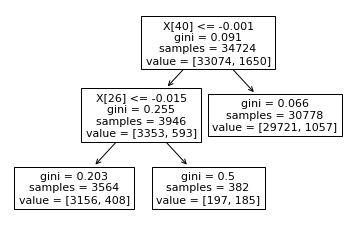

In [27]:
clf = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
)
clf.fit(X_train, y_train)
tree.plot_tree(clf.named_steps["decisiontreeclassifier"])
plt.show()

<font size="4" color='red'> Further research will be done with the RandomForest | GradientBoosting and GridSearchCV</font>


# 6. Making pipeline with RandomForestClassifier

In [28]:
clf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [29]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

[0.99818594 0.99780801 0.99697657 0.99848817 0.99712752]


## make pipeline with GridSearchCV

In [30]:
params = {
    "simpleimputer__strategy": ["median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [31]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['median']},
             verbose=1)

In [32]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['median']},
             verbose=1)

In [33]:
#cv_results = pd.DataFrame(model.cv_results_)
#cv_results.head()

results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,36.863084,2.751162,0.314767,0.071418,40,75,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.998186,0.997808,0.997052,0.998110,0.996145,0.997460,0.000770,1
10,29.562406,0.216655,0.383537,0.025893,40,50,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.998035,0.997732,0.997128,0.997959,0.996069,0.997385,0.000731,2
8,42.655502,0.535442,0.539657,0.019713,30,75,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997732,0.997506,0.996901,0.997657,0.996372,0.997233,0.000521,3
7,28.657657,0.184528,0.366999,0.005407,30,50,median,"{'randomforestclassifier__max_depth': 30, 'ran...",0.997581,0.997506,0.996825,0.997959,0.995994,0.997173,0.000694,4
9,14.799641,0.078316,0.196047,0.017440,40,25,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.997506,0.997279,0.996674,0.997657,0.995994,0.997022,0.000613,5


In [34]:
# Extract best hyperparameters
best_params = model.best_params_
best_score = model.best_score_
best_estimator = model.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'randomforestclassifier__max_depth': 40, 'randomforestclassifier__n_estimators': 75, 'simpleimputer__strategy': 'median'}
0.9974602306129363
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=75,
                                        random_state=42))])


In [35]:
# predict with using the best model
model.predict(X_train_over)

array(['0', '0', '0', ..., '1', '1', '1'], dtype=object)

In [36]:
acc_test = accuracy_score(y_test, model.predict(X_test))
precision_test = accuracy_score(y_test, model.predict(X_test))
recall_score_test = recall_score(y_test, model.predict(X_test), average='macro')    
f1_score_test = f1_score(y_test, model.predict(X_test), average='macro')
print(Fore.BLUE + "Accuracy:", round(acc_test, 4))
print("Precision:", round(precision_test, 4))
print("Recall:", round(recall_score_test, 4))
print("F1_Score:", round(f1_score_test, 4))

Accuracy: 0.9639
Precision: 0.9639
Recall: 0.6773
F1_Score: 0.7418


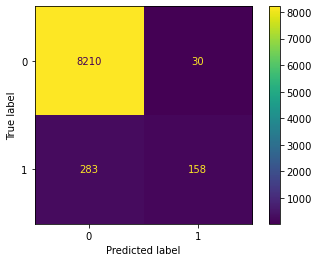

In [37]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

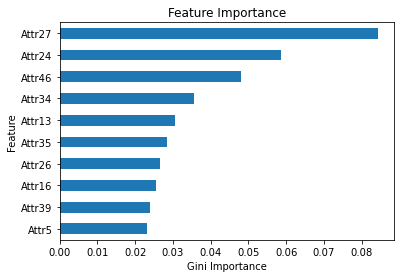

In [38]:
# Get feature names from training data
features = X_train_over.columns

# Extract importances from model
importances = model.best_estimator_.named_steps[
    "randomforestclassifier"
].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [39]:
# Save model
with open("model-polish-companies-RF.pkl", "wb") as f:
    pickle.dump(model, f)

# 7. Making pipeline with GradientBoostingClassifier

In [40]:
clf = make_pipeline(
    SimpleImputer(),
    GradientBoostingClassifier()
)

In [41]:
params = {
    "simpleimputer__strategy": ["median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [42]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

In [43]:
# Fit model to over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['median']},
             verbose=1)

In [44]:
# Save model
with open("model-polish-companies-GB.pkl", "wb") as f:
    pickle.dump(model, f)

In [45]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,55.941302,3.276669,0.079554,0.009296,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.874906,0.879743,0.876644,0.870965,0.874820,0.875416,0.002851,1
7,53.847194,0.608407,0.146393,0.013641,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.867725,0.872940,0.871353,0.862726,0.867035,0.868356,0.003573,2
6,43.278166,0.770342,0.188043,0.069166,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.859335,0.865306,0.863114,0.853730,0.860760,0.860449,0.003929,3
5,48.380241,0.390429,0.135162,0.016233,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.837793,0.837944,0.838322,0.837176,0.830146,0.836276,0.003087,4
4,40.325240,0.393001,0.128626,0.021200,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.829327,0.836432,0.831822,0.830221,0.823569,0.830274,0.004151,5


In [46]:
# Extract best hyperparameters
best_params = model.best_params_
best_score = model.best_score_
best_estimator = model.best_estimator_

print(best_params)
print(best_score)
print(best_estimator)

{'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 30, 'simpleimputer__strategy': 'median'}
0.8754156581371684
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, n_estimators=30))])


In [47]:
# predict with using the best model
model.predict(X_train_over)

array(['0', '0', '0', ..., '1', '0', '1'], dtype=object)

In [48]:
acc_test = accuracy_score(y_test, model.predict(X_test))
precision_test = accuracy_score(y_test, model.predict(X_test))
recall_score_test = recall_score(y_test, model.predict(X_test), average='macro')    
f1_score_test = f1_score(y_test, model.predict(X_test), average='macro')
print(Fore.BLUE + "Accuracy:", round(acc_test, 4))
print("Precision:", round(precision_test, 4))
print("Recall:", round(recall_score_test, 4))
print("F1_Score:", round(f1_score_test, 4))

Accuracy: 0.8615
Precision: 0.8615
Recall: 0.8369
F1_Score: 0.6474


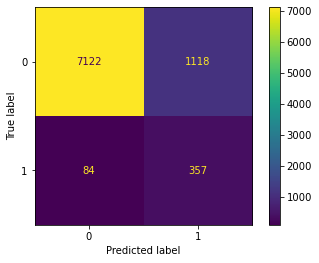

In [49]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

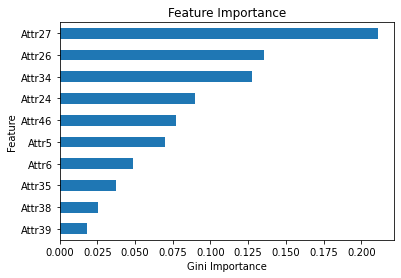

In [50]:
# Get feature names from training data
features = X_train_over.columns

# Extract importances from model
importances = model.best_estimator_.named_steps[
    "gradientboostingclassifier"
].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

# 8. Communication

In [51]:
df_sample = df.sample(frac=0.01, random_state=42).drop(columns=['class']).reset_index()
df_sample.to_json('data/sample_test.json')

In [52]:
def make_predictions(data_filepath, model_filepath):
    
    # Wrangle JSON file
    data = json.load(open(data_filepath))
    X_test = pd.DataFrame().from_dict(data).set_index("index", drop=True)
    
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    
    # Generate predictions
    y_test_pred = model.predict(X_test)
    df_ = pd.DataFrame(y_test_pred, index=X_test.index, columns=["default"]).reset_index()
    
    return df_

In [53]:
df_ = make_predictions(
    data_filepath="data/sample_test.json",
    model_filepath="model-polish-companies-RF.pkl",
)
print(df_["default"].value_counts())

0    426
1      8
Name: default, dtype: int64


In [54]:
df_ = make_predictions(
    data_filepath="data/sample_test.json",
    model_filepath="model-polish-companies-GB.pkl",
)
print(df_["default"].value_counts())

0    372
1     62
Name: default, dtype: int64
